<a href="https://colab.research.google.com/github/TienLungSun/PyTorch-Colab/blob/main/999%20Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla T4


In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
import torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [ ]:
# 用手機拍一段小的影片,上傳
from google.colab import files
uploaded = files.upload()

Saving street-short.mp4 to street-short.mp4


In [ ]:
fnameLst = list(uploaded.keys())
fname = fnameLst[0]
print(fname)

street-short.mp4


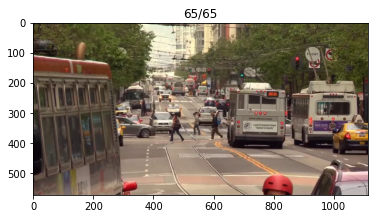

In [ ]:
# take a look at the input video
import cv2
import imageio
import matplotlib.pyplot as plt
from IPython import display

cap = cv2.VideoCapture(fname)
total_frames = int(cap.get(7))
vid = imageio.get_reader(fname, 'ffmpeg')
print('No. of frames = ', total_frames)
frame_count = 1
try:
  while(frame_count <= total_frames):
    display.clear_output(wait=True)
    plt.title(str(frame_count)+'/'+str(total_frames))
    frame = vid.get_data(frame_count)  # Capture frame-by-frame
    frame_count += 1
    plt.imshow(frame)
    plt.pause(0.1)
except:
    print("Read video error!")

In [ ]:
rect_th=3
text_th=3
text_size=3
fname1 = fname + '_processed_video.mp4'

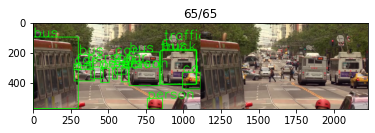

In [ ]:
import numpy as np
from torchvision import transforms

cap = cv2.VideoCapture(fname)
vid = imageio.get_reader(fname, 'ffmpeg')
fps = vid.get_meta_data()['fps']
writer = imageio.get_writer(fname1, fps=fps)
total_frames = int(cap.get(7))
print('No. of frames = ', total_frames)
frame_count = 1
try:
  while(frame_count <= total_frames):
    display.clear_output(wait=True)
    plt.title(str(frame_count)+'/'+str(total_frames))
    frame = vid.get_data(frame_count)  # Capture frame-by-frame
    img0 = np.copy(frame)
    transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
    img = transform(frame).to(device) # Apply the transform to the image
    pred = model([img]) # Pass the image to the model
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())] # Get the Prediction Score
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].cpu().detach().numpy())] # Bounding boxes
    pred_score = list(pred[0]['scores'].cpu().detach().numpy())
    i = 0
    while i < len(pred_score):
        if (pred_score[i] < 0.9): # 找出 score > RecognitionThreshold 的最小 idx
            break
        i = i + 1
    pred_boxes = pred_boxes[:i]
    pred_class = pred_class[:i]
    if(len(pred_boxes) != 0):
      for i in range(len(pred_boxes)):
        cv2.rectangle(frame, pred_boxes[i][0], pred_boxes[i][1],color=(0, 255, 0), thickness=rect_th) 
        cv2.putText(frame,pred_class[i], pred_boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) 
    img1 = np.append(frame,img0, axis=1)#把 2 張 img 接起來
    writer.append_data(img1)
    frame_count += 1
    plt.imshow(img1)
    plt.pause(0.1)
except:
    print("Read video error!")
writer.close()